Fichier de test 2d HL-RF


Starting a 2d version of iHL-RF to understand well how it works


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#start the global attack function as an object

class HLRF_attack:
	def __init__(self, f, deltaf, c=2, x0 = (0,0), maxiter = 100,tau = 0.5, omega = 1e-2,epsilon = 0):
		self.f = lambda x: f(x) + epsilon
		self.deltaf = deltaf
		self.c = c
		self.omega = omega
		self.tau = tau
		self.x0 = x0
		self.maxiter = maxiter
		self.x = x0
		self.xs = [x0]
		self.fs = [f(x0)]
		self.dfs = [deltaf(x0)]
		self.ds = [self.descent_direction()]
		self.sig = 0
		self.sigmas = []
		self.arm = []
		self.delta = abs(f(x0)) * 10**(-3)
		self.epsilon = epsilon
		self.best_x = x0
		self.found_adv = False

	def descent_direction(self):
		if np.linalg.norm(self.deltaf(self.x)) == 0:
			return np.zeros_like(self.x)
		else:
			return ((np.dot(self.deltaf(self.x),self.x)-self.f(self.x))/(np.linalg.norm(self.deltaf(self.x),2)**2)) * self.deltaf(self.x) - self.x

	def merit_function(self, x):
		return 0.5 * np.linalg.norm(x)**2 + self.sig * abs(self.f(x))

	def grad_merit_function(self, x):
		return np.linalg.norm(x) + self.c * self.deltaf(x) * (1 if self.f(x) > 0 else -1)


	def armijo(self):
		mer = self.merit_function(self.x)
		grad_mer = self.grad_merit_function(self.x)
		armijo_cond = self.omega * np.dot(grad_mer,self.ds[-1])
		bool_arm_cond = True
		i=0
		while(bool_arm_cond and i<10):
			next_mer = self.merit_function(self.x+self.tau**i * self.ds[-1])
			bool_arm_cond = not(next_mer < self.tau**i * armijo_cond + mer)
			i+=1
		self.arm.append(self.tau**i)
		return self.tau**(i)


	def step(self):
		dsc_dir = self.descent_direction()
		self.ds.append(dsc_dir)
		tau_armijo = self.armijo()
		self.x = self.x + tau_armijo * dsc_dir
		self.xs.append(self.x)
		self.fs.append(self.f(self.x))
		self.dfs.append(self.deltaf(self.x))
		if self.f(self.x) < 0 and not(self.found_adv):
			self.best_x = self.x
			self.found_adv = True
		elif np.linalg.norm(self.x) < np.linalg.norm(self.best_x) and self.found_adv and self.f(self.x) < 0:
			self.best_x = self.x
		elif self.f(self.x) < self.f(self.best_x) and not(self.found_adv):
			self.best_x = self.x
		

	def sigma(self):
		if (abs(self.f(self.x)) >= self.delta):
			self.sig = self.c * max(np.linalg.norm(self.x)/np.linalg.norm(self.deltaf(self.x)),0.5 * np.linalg.norm(self.x - self.ds[-1])**2 / abs(self.f(self.x)))
		else:
			self.sig = self.c * np.linalg.norm(self.x)/np.linalg.norm(self.deltaf(self.x))
		self.sigmas.append(self.sig)


	def __call__(self):
		print("Starting the attack")
		for i in range(self.maxiter):
			self.sigma()
			self.step()
		if not(self.found_adv):
			print("No adversarial example found")

class nHLRF_attack(HLRF_attack):
	def __init__(self, f, deltaf, c=10, x0=(0, 0), maxiter=100 , tau=1, omega=0.01, omega2=0.9,epsilon=0):
		super().__init__(f, deltaf, c, x0, maxiter, tau, omega,epsilon)
		self.omega2 = omega2
		self.sig = 100

	def merit_function(self, x):
		# try to return the value, if it is not possible, return a very big number
		try:
			return 0.5 * np.linalg.norm(x)**2 + 0.5 * self.sig * self.f(x)**2
		except:
			return 10**10

	def grad_merit_function(self, x):
		return np.linalg.norm(x) + self.sig * self.deltaf(x) * self.f(x)

	def armijo(self):
		tau = self.tau
		mer = self.merit_function(self.x)
		grad_mer = self.grad_merit_function(self.x)
		armijo_cond = self.omega * np.dot(grad_mer,self.ds[-1])
		wolfe_cond = self.omega2 * np.dot(grad_mer,self.ds[-1])
		bool_cond = True
		i=0
		while bool_cond and i<10:
			next_mer = self.merit_function(self.x + tau**i * self.ds[-1])
			grad_next_mer = self.grad_merit_function(self.x + tau**i * self.ds[-1])
			if next_mer > mer + tau * armijo_cond:
				tau = 0.5 * tau
			elif np.dot(self.ds[-1],grad_next_mer) < wolfe_cond:
				tau = 2 * tau
			else:
				bool_cond = False
			i+=1
		self.arm.append(tau)
		return tau

	def sigma(self):
		if self.f(self.x) == 0 :
			self.sig = self.c
		elif np.linalg.norm(self.deltaf(self.x)) == 0:
			print('norm grad nul')
			self.sig = 0
		else:
			self.sig = self.c * abs(np.dot(self.x,self.deltaf(self.x))/ (np.linalg.norm(self.deltaf(self.x))**2 * self.f(self.x)))
		self.sigmas.append(self.sig)

Create a function we want to test


5.866894789156265
[-1.79329804  2.07459927]


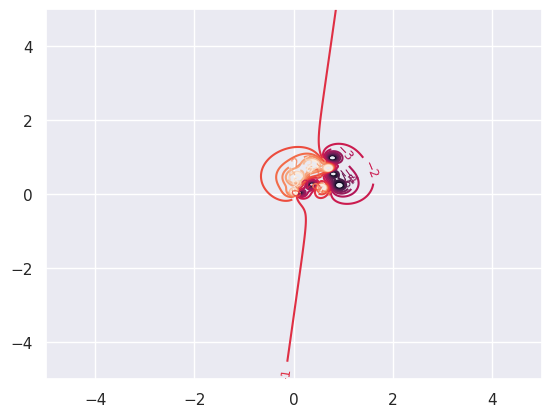

In [121]:
#test with a function f(x) = sum ci/(norm(x-xi)+epsilon) where ci are +-1 and xi are random points in R^2
#and its gradient deltaf(x) = sum ci/(2*(norm(x-xi)**2+epsilon)) 
#where epsilon is a small number to avoid division by zero
#to assure that f(0)>0 ,the closer point xi to 0 have a ci=1

def f(x):
	return 0
x0 = np.array([0,0])
while(f(x0))<=0:
	c = np.random.choice([-1,1],size=10)
	xi = np.random.rand(10,2)
	i = np.argmin(np.linalg.norm(xi,axis=1))
	c[i] = 1
	epsilon = 10**(-2)

	def f(x):
		return np.sum(c/(np.linalg.norm(x-xi,axis=1) + epsilon)) -1

	def deltaf(x):
		a =  c/(2*(np.linalg.norm(x-xi,axis=1)**2 + epsilon))
		d = np.zeros((10,2))
		for i in range(10):
			b = np.zeros(2)
			for j in range(2):
				b[j] = a[i] * (x[j]-xi[i,j])
			d[i] = b
		return -np.sum(d,axis=0)



print(f(x0))
print(deltaf(x0))

sns.set()
x = np.linspace(-5,5,1000)
y = np.linspace(-5,5,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
plt.show()

Create an other function

In [122]:
# add a new function g((x1,x2)) = r - 1.5 + cos**2(theta(r))(x1-1)**2 + sin**2(theta(r))x2**2 + sin(2theta(r))(x1-1)x2 + cos(theta(r))x1 - sin(theta(r))x2
# where theta(r) = pi/72 * r + 13pi/18
# and r = 1,2,3,4,5,6,7,8,9,10
# and the gradient of g is delta_g(x) = (2*cos**2(theta(r))(x1-1) + sin(2theta(r))x2 + cos(theta(r)), sin**2(theta(r))x2 + sin(2theta(r))(x1-1) - sin(theta(r)))
# we want to find the point x such that g(x) = 0
r = 7
def g(x):
	theta = np.pi/72 * r + 13*np.pi/18
	return r - 1.5 + np.cos(theta)**2 * (x[0]-1)**2 + np.sin(theta)**2 * x[1]**2 + np.sin(2*theta) * (x[0]-1) * x[1] + np.cos(theta) * x[0] - np.sin(theta) * x[1]

def delta_g(x):
	theta = np.pi/72 * r + 13*np.pi/18
	return np.array([2*np.cos(theta)**2 * (x[0]-1) + np.sin(2*theta) * x[1] + np.cos(theta), 2*np.sin(theta)**2 * x[1] + np.sin(2*theta) * (x[0]-1) - np.sin(theta)])

Test the function above


5.866894789156265
[-1.79329804  2.07459927]
Starting the attack
[ 0.05535806 -0.02288   ] x final

-1.8841677906777932e-07 f(x) final
[-3.17202687  1.31098672] deltaf(x) final
[-1.79329804  2.07459927] deltaf(x) initial
[ 1.39910357 -1.61857046] descent dir initial
[ 0.69955179 -0.80928523] x1-x0
[ 0.05535806 -0.02288   ] best x found
-1.8841677906777932e-07 best f(x) found
0.059899994879570574 norm of best x found


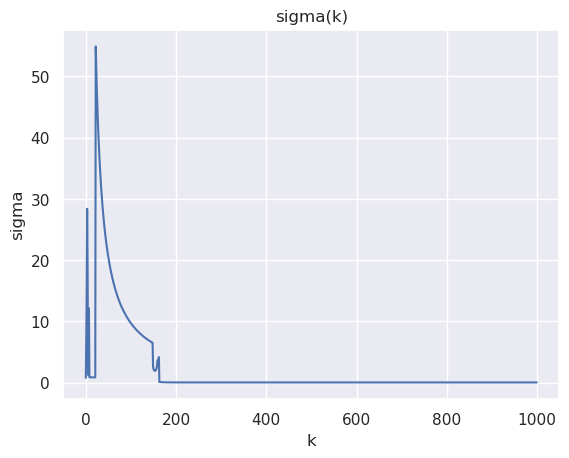

In [123]:
#test the attack
print(f((0,0)))
print(deltaf((0,0)))
attack = HLRF_attack(f,deltaf,maxiter=1000,epsilon=0)
attack()
print(attack.x,"x final\n")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.dfs[0],"deltaf(x) initial")
print(attack.ds[0],"descent dir initial")
print(attack.xs[1] - attack.xs[0],"x1-x0")
print(attack.best_x,"best x found")
print(attack.f(attack.best_x),"best f(x) found")
print(np.linalg.norm(attack.best_x),"norm of best x found")

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 0.5
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 0.5

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black
sns.set()
x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='red')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(0,0,color='red')
#ax.plot(attack.best_x[0],attack.best_x[1],'black',marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en rouge')
plt.show()

#plot the function f at the points x0,x1,...,xk with seaborn
sns.set()
plt.subplots()
plt.plot(attack.fs)
plt.xlabel('k')
plt.ylabel('f(xk)')
plt.title('f(xk) en fonction de k')
plt.show()

sns.set()
plt.subplots()
plt.plot(np.linalg.norm(attack.xs,axis=1))
plt.xlabel('k')
plt.ylabel('||xk||')
plt.title('||xk|| en fonction de k')
plt.show()

Pareil avec fonction de merite de nhl-rf


1.1943517915800328
[0.58807305 0.2742307 ]
Starting the attack
No adversarial example found
[-0.7300126  -0.35794825] x final
0.23565279990485122 f(x) final
[0.49893653 0.24763559] deltaf(x) final
[-0.7300126  -0.35794825] best x found
0.23565279990485122 best f(x) found
0.8130469484582756 norm of best x found


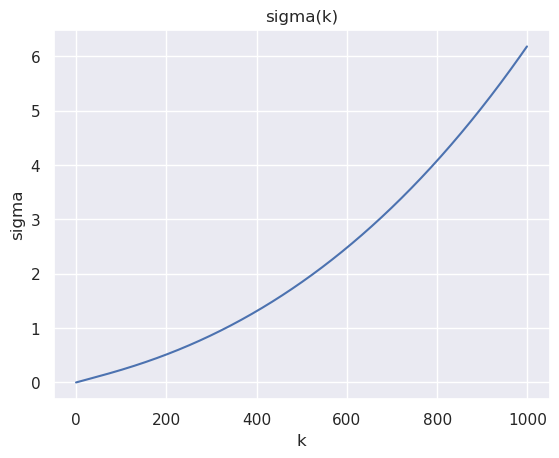

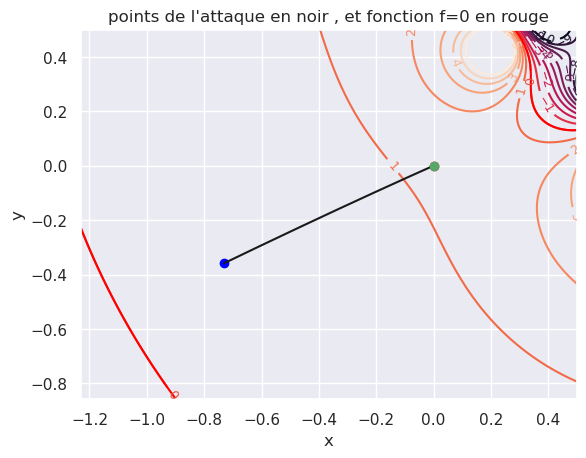

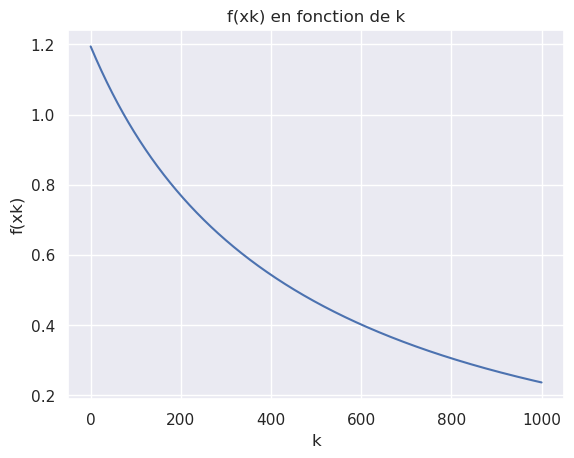

In [ ]:
#test the attack
print(f((0,0)))
print(deltaf((0,0)))
attack = nHLRF_attack(f,deltaf,maxiter=1000,omega=0.1,omega2=0.9)
attack()
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.best_x,"best x found")
print(attack.f(attack.best_x),"best f(x) found")
print(np.linalg.norm(attack.best_x),"norm of best x found")

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 0.5
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 0.5

fig,ax = plt.subplots()
ax.plot(attack.sigmas)
ax.set_xlabel('k')
ax.set_ylabel('sigma')
ax.set_title('sigma(k)')
plt.show()

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black
sns.set()
x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))
for i in range(1000):
	for j in range(1000):
		Z[i,j] = f((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,levels=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='red')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(0,0,color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en rouge')
plt.show()

#plot the function f at the points x0,x1,...,xk with seaborn
sns.set()
plt.subplots()
plt.plot(attack.fs)
plt.xlabel('k')
plt.ylabel('f(xk)')
plt.title('f(xk) en fonction de k')
plt.show()

Starting the attack
No adversarial example found
(3.1458393566574996, 2.9547209901235068) x initial
1.308633795190172 f(x) initial
[3.84994036 4.22607382] x final
4.6154334887305026e-07 f(x) final
[-0.61913785 -0.6801649 ] deltaf(x) final
[0.25, 0.0625, 0.25, 0.0625, 0.5, 0.0625, 0.25, 0.03125, 0.125, 0.25, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.015625, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.015625, 0.03125, 0.125, 0.25, 0.03125, 0.125, 0.25, 0.03125, 0.125, 0.25, 0.03125, 0.125, 0.25, 0.03125, 0.125, 0.25, 0.03125, 0.125, 0.25, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.03125, 0.03125, 0.0625, 0.5, 0.0625, 0.5, 0.015625, 0.03125, 0.0625, 0.5, 0.125, 0.03125, 0.125, 0.5, 0.001953125, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765625, 0.0009765

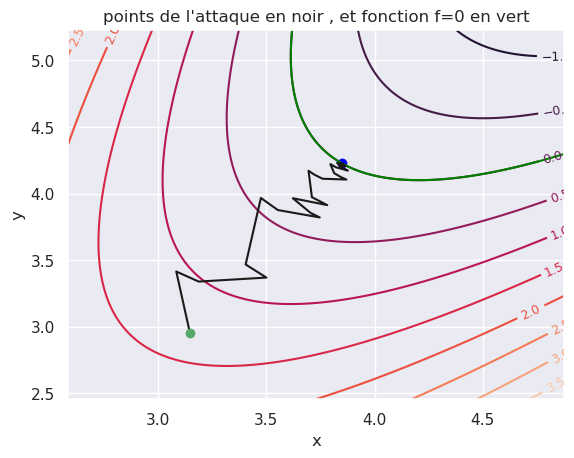

In [ ]:
attack = HLRF_attack(g,delta_g,maxiter=100,epsilon=0,x0=(0,0))
attack()
print(attack.xs[0],"x initial")
print(attack.fs[0],"f(x) initial")
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.arm,'armijo')

#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black

x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 1
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 1

sns.set()
x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))	
for i in range(1000):
	for j in range(1000):
		Z[i,j] = g((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,10)
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='green')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
#ax.scatter(0,0,color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en vert')
plt.show()

Starting the attack
No adversarial example found
(0, 0) x initial
6.21130913087035 f(x) initial
[ 0.27760358 -0.0306689 ] x final
5.633743446095578 f(x) final
[-1.84329032  0.09970623] deltaf(x) final
[ 2.67026652 -0.43483935]
[array([ 2.67026652, -0.43483935]), array([ 2.67026652, -0.43483935]), array([ 2.673217  , -0.43302273]), array([ 2.67618223, -0.43119143]), array([ 2.67916227, -0.4293453 ]), array([ 2.6821572 , -0.42748419]), array([ 2.68516708, -0.42560797]), array([ 2.68819197, -0.42371646]), array([ 2.69123194, -0.42180954]), array([ 2.69428705, -0.41988703]), array([ 2.69735738, -0.4179488 ]), array([ 2.70044298, -0.41599468]), array([ 2.70354393, -0.41402451]), array([ 2.70666029, -0.41203814]), array([ 2.70979213, -0.4100354 ]), array([ 2.71293951, -0.40801614]), array([ 2.7161025 , -0.40598018]), array([ 2.71928117, -0.40392736]), array([ 2.72247558, -0.40185751]), array([ 2.72568579, -0.39977046]), array([ 2.72891188, -0.39766603]), array([ 2.73215391, -0.39554406]), ar

/tmp/ipykernel_2800/2054003329.py:41: UserWarning: No contour levels were found within the data range.
  ax.contour(X,Y,Z,levels=[0],colors='green')


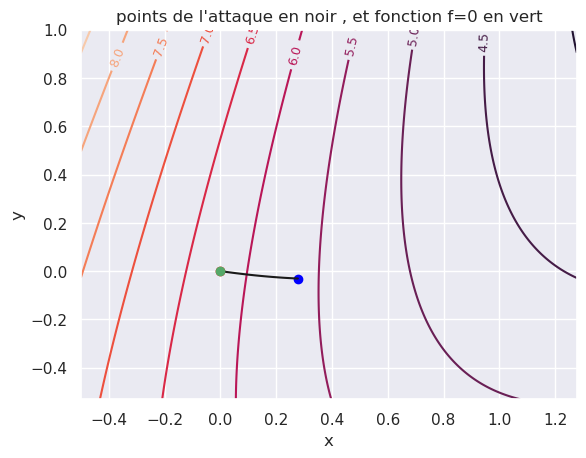

In [ ]:
attack = nHLRF_attack(g,delta_g,maxiter=100,omega=0.1,omega2=0.9,x0=(0,0))
attack()
print(attack.xs[0],"x initial")
print(attack.fs[0],"f(x) initial")
print(attack.x,"x final")
print(attack.fs[-1],"f(x) final")
print(attack.dfs[-1],"deltaf(x) final")
print(attack.ds[0])
print(attack.ds,'descent dir')
print(attack.arm,'armijo')


x_attack = [x[0] for x in attack.xs]
y_attack = [x[1] for x in attack.xs]
x_min = min(x_attack) - 0.5
x_max = max(x_attack) + 1
y_min = min(y_attack) - 0.5
y_max = max(y_attack) + 1


#plot the results of the attack and the function f and its gradient deltaf in the plane R^2 with seaborn
#the point x such that f(x)=0 is in red
#the points xi are in blue
#the points x0 and x are in green
#the points xk and xk+1 are linked by a line in black



sns.set()
x = np.linspace(x_min,x_max,1000)
y = np.linspace(y_min,y_max,1000)
X,Y = np.meshgrid(x,y)
Z = np.zeros((1000,1000))	
for i in range(1000):
	for j in range(1000):
		Z[i,j] = g((X[i,j],Y[i,j]))

fig, ax = plt.subplots()
cs = ax.contour(X,Y,Z,10)
ax.clabel(cs, fontsize=9, inline=True)
ax.contour(X,Y,Z,levels=[0],colors='green')
xs_x = [x[0] for x in attack.xs]
xs_y = [x[1] for x in attack.xs]
ax.plot(xs_x,xs_y,'-k')
ax.plot(xs_x[0],xs_y[0],'og')
ax.scatter(attack.x[0],attack.x[1],color='blue')
#ax.scatter(xi[:,0],xi[:,1],color='blue')
ax.scatter(0,0,color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('points de l\'attaque en noir , et fonction f=0 en vert')
plt.show()